$IMPORTING$ $ESSENTIAL$ $LIBRARIES$

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
torch.manual_seed(0)
import time
import os
from torchvision.datasets import ImageFolder

$HYPERPARAMETERS$

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
learning_rate = 0.0001

$SPECIAL$ $FUNCTIONS$

In [3]:
# Function for getting parameters from user
def get_parameters():
    neuron_list = []
    for i in range(5):
        neuron_list.append(input(print(f"Enter the number of neuorns needed in your neural network layer{i}: ")))
    return neuron_list

# Function for showing examples
def show_example(img):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = ' + str(data_sample[1]))
    
# Function for showing data
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE),cmap = 'gray')
    plt.title('y = ' + str(data_sample[1]))

# Transforms or data augmentation
transform_ = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
#     transforms.RandomRotation((-30,30)),
#     transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

# Function for loading our dataset and augmenting it
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_filenames = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if fname.endswith('.jpg')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = self.image_filenames[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

$DATASET$   $LOADING$   $AND$   $SPLITTING$

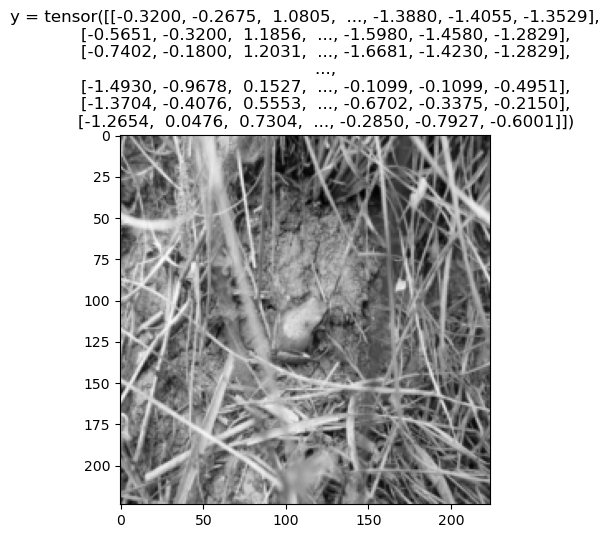

In [4]:
# Train and validation paths defined (dataset is present in local computer with the files located at the following locations)
train_path = 'D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/train'
val_path = 'D:/LowLight_Colorization/Datasets/inaturalist/nature_12K/inaturalist_12K/val'

# Train and validation datasets defined
train_dataset = ImageFolder(train_path, transform=transform_)
val_dataset = ImageFolder(root = val_path, transform = transform_)

# Splitting the training data into 80-20 ratio for hyperparameter sweeping in wandb
train_set, sweep_set = torch.utils.data.random_split(train_dataset, [7999, 2000])

#Train and validation data loader defined
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

# Taking and displaying first class first image
show_data(val_dataset[0][0])

$STRUCTURE$ $OF$ $THE$ $CONVOLUTION$ $NEURAL$ $NETWORK$ $DEFINED$

In [5]:
class CNN(nn.Module):

    def __init__(self, input_channels=3, o1=128, o2=64, o3=32, o4=16, o5=16, o6 = 128, o7=10):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=input_channels, out_channels=o1, kernel_size=5, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(o1) 
        self.relu1 = nn.LeakyReLU(0.2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=o1, out_channels=o2, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(o2)
        self.relu2 = nn.LeakyReLU(0.2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn3 = nn.Conv2d(in_channels=o2, out_channels=o3, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(o3)
        self.relu3 = nn.LeakyReLU(0.2)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
            
        self.cnn4 = nn.Conv2d(in_channels=o3, out_channels=o4, kernel_size=1)
        self.bn4 = nn.BatchNorm2d(o4)
        self.relu4 = nn.LeakyReLU(0.2)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2)
        
        self.cnn5 = nn.Conv2d(in_channels=o4, out_channels=o5, kernel_size=1)
        self.bn5 = nn.BatchNorm2d(o5)
        self.relu5 = nn.LeakyReLU(0.2)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layers
        
        self.flatten = nn.Flatten(start_dim=1, end_dim = -1)
        
        self.fc1 = nn.Linear(144, o6)
        self.bn_fc1 = nn.BatchNorm1d(o6)
        self.relu_fc1 = nn.ReLU()
        self.fc2 = nn.Linear(o6, o7)


    def forward(self, x):
        x = self.cnn1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        x = self.cnn3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
    
        x = self.cnn4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.maxpool4(x)

        x = self.cnn5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = self.relu_fc1(x)
        x = self.fc2(x)
        return x

# Loss function is defined
criterion = nn.CrossEntropyLoss()

# Create model using the CNN class defined above
model = CNN(input_channels=3, o1=128, o2=64, o3=32, o4=16, o5=16, o7=10)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

$TRAINING$   

In [6]:
start_time = time.time()

cost_list = []
accuracy_list = []
N_test = len(val_dataset)

# Train the model and calculate the loss and accuracy
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    train_correct = 0
    for data, target in train_dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss += loss.item()

    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for data, target in val_dataloader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            test_correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_dataloader.dataset)
    test_loss /= len(val_dataloader.dataset)
    train_accuracy = train_correct / len(train_dataloader.dataset)
    test_accuracy = test_correct / len(val_dataloader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.2f}% \tTest Loss: {:.6f} \tTest Accuracy: {:.2f}%'.format(epoch, train_loss, 100. * train_accuracy, test_loss, 100. * test_accuracy))


Epoch: 0 	Training Loss: 0.068123 	Training Accuracy: 20.42% 	Test Loss: 0.066565 	Test Accuracy: 23.55%
Epoch: 1 	Training Loss: 0.064133 	Training Accuracy: 27.19% 	Test Loss: 0.064497 	Test Accuracy: 27.00%
Epoch: 2 	Training Loss: 0.061806 	Training Accuracy: 30.70% 	Test Loss: 0.062502 	Test Accuracy: 29.70%
Epoch: 3 	Training Loss: 0.060233 	Training Accuracy: 32.48% 	Test Loss: 0.061664 	Test Accuracy: 31.20%
Epoch: 4 	Training Loss: 0.058520 	Training Accuracy: 34.98% 	Test Loss: 0.060160 	Test Accuracy: 33.05%
Epoch: 5 	Training Loss: 0.057340 	Training Accuracy: 36.03% 	Test Loss: 0.059954 	Test Accuracy: 34.50%
Epoch: 6 	Training Loss: 0.056122 	Training Accuracy: 37.37% 	Test Loss: 0.058754 	Test Accuracy: 36.25%
Epoch: 7 	Training Loss: 0.054869 	Training Accuracy: 39.05% 	Test Loss: 0.058539 	Test Accuracy: 35.85%
Epoch: 8 	Training Loss: 0.053472 	Training Accuracy: 40.21% 	Test Loss: 0.057937 	Test Accuracy: 35.25%
Epoch: 9 	Training Loss: 0.052124 	Training Accuracy: 4